## Import Packages
Import packages needed in this project


In [5]:
# import packages
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, MaxPooling2D, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import io

## Generate Dataset

Determine the train and validation data paths, then use ImageDataGenerator on the train data and validation data.

In [10]:
# determine the training and validation dataset directories
train_dir = r"C:\Users\soumya\Desktop\Music\Micro_Expressions\train"
valid_dir = r"C:\Users\soumya\Desktop\Music\Micro_Expressions\test"

# determine the image size
img_width, img_height, channel = (224, 224, 3)

# use ImageDataGenerator on train and validation data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_width, img_height),
    batch_size = 64,
    class_mode = 'categorical'
)

Found 7600 images belonging to 7 classes.


In [11]:
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size = (img_width, img_height),
    batch_size = 64,
    class_mode = 'categorical'
)

Found 1860 images belonging to 7 classes.


In [12]:
classes = train_data.class_indices
classes

{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'happiness': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

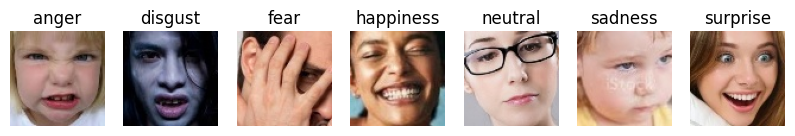

In [7]:
# look at one picture from each class
def display_images_from_each_class(class_folder_path):
    fig, axs = plt.subplots(1, len(os.listdir(class_folder_path)), figsize=(10, 4))

    for i, class_name in enumerate(sorted(os.listdir(class_folder_path))):
        class_path = os.path.join(class_folder_path, class_name)
        img_files = os.listdir(class_path)

        # Randomly select an image from the class folder
        img_file = random.choice(img_files)
        img_path = os.path.join(class_path, img_file)

        img = mpimg.imread(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(class_name)

    plt.show()

class_folder = r"C:\Users\soumya\Desktop\Music\Micro_Expressions\train"
display_images_from_each_class(class_folder)

## Making Models

Model creation using the MobileNetV3-Large pretrained model. <br>
Then add additions to the model architecture by adjusting the dataset conditions.

In [3]:
# create a basic model
from tensorflow.keras.applications import MobileNetV3Large

base_model = MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    classes=7,
    input_shape=(224, 224, 3)
)

# freeze the layer
for layer in base_model.layers[:-10]:
    layer.trainable = False

base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                         

In [6]:
# adding several layers to adjust the dataset
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(7, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

## Compile Model
Determine the optimizer, loss, and metrics that will be displayed during training.

In [7]:
# compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Create Callbacks

Create callbacks that can be used during model training to make it easier to monitor the training process.

In [8]:
# create callbacks
checkpoint = ModelCheckpoint(filepath="emotion_detection.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.01,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_learningrate = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

## Creating a Fit Model

Determine epoch, callback, and verbose for the training process.

In [ ]:
# create fit model
history = model.fit(
    train_data,
    validation_data = valid_data,
    epochs = 100,
    callbacks = [callbacks_list],
    verbose = 1
)

## Evaluate

Evaluate training results by displaying metrics and graphs of loss and accuracy from the training process.

In [ ]:
# evaluation of model results
model.evaluate(valid_data)

In [ ]:
# loss diagram during training
plt.figure(figsize=(5, 4))
plt.plot(history.epoch, history.history['loss'])
plt.plot(history.epoch, history.history['val_loss'])
plt.legend(['train loss', 'val loss'])
plt.title('Loss Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
plt.show()

In [ ]:
# Accuracy diagram during training
plt.figure(figsize=(5, 4))
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.legend(['train acc', 'val acc'])
plt.title('Acc Diagram')
plt.xlabel('Epoch(s)')
plt.ylabel('Acc')
plt.show()

# Save Model

Save the trained model.

In [ ]:
# save model
model.save('emotion_detection.h5')

## Load Model and Run Model

Using the results of a model that has been trained and loaded for testing.

In [24]:
# load model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

path_model_save = r"C:\Users\soumya\Desktop\Music\emotion_detection.h5"
loaded_model = load_model(path_model_save)

## Make Predictions
Testing previously trained models with data that has never been encountered.

1/1 [==============================] - 3s 3s/step


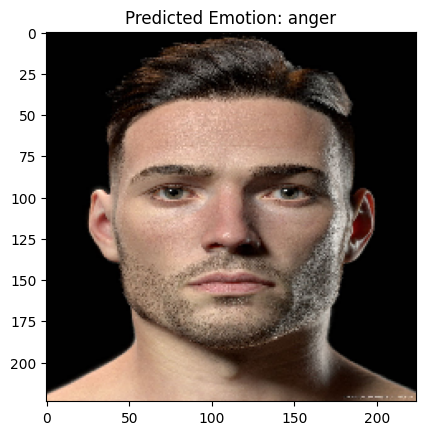

Probabilities anger: 0.3653
Probabilities disgust: 0.0185
Probabilities fear: 0.0240
Probabilities happiness: 0.1527
Probabilities neutral: 0.0619
Probabilities sadness: 0.2029
Probabilities surprise: 0.1746


In [25]:
# Load and preprocessing images
path = "test.jpg"
img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Make predictions
predictions = loaded_model.predict(x)

# Look for the label with the highest probability
emotion_labels = ['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']
predicted_label = emotion_labels[np.argmax(predictions)]
predicted_prob = predictions[0]

# Displays images and emotion predictions
import matplotlib.pyplot as plt

plt.imshow(img)
plt.title(f'Predicted Emotion: {predicted_label}')
plt.show()

# Displays the prediction results for each label
for label, prob in zip(emotion_labels, predicted_prob):
    print(f'Probabilities {label}: {prob:.4f}')


# Music Recommendations

Make several music recommendations based on emotional prediction results.

In [26]:
mood_music = pd.read_csv("data_moods.csv")
mood_music.head()

,name,album,artist,id,release_date,popularity,length,danceability,acousticness,energy,instrumentalness,liveness,valence,loudness,speechiness,tempo,key,time_signature,mood
0,1999,1999,Prince,2H7PHVdQ3mXqEHXcvclTB0,1982-10-27,68,379266,0.866,0.13700,0.730,0.000000,0.0843,0.625,-8.201,0.0767,118.523,5,4,Happy
1,23,23,Blonde Redhead,4HIwL9ii9CcXpTOTzMq0MP,2007-04-16,43,318800,0.381,0.01890,0.832,0.196000,0.1530,0.166,-5.069,0.0492,120.255,8,4,Sad
2,9 Crimes,9,Damien Rice,5GZEeowhvSieFDiR8fQ2im,2006-11-06,60,217946,0.346,0.91300,0.139,0.000077,0.0934,0.116,-15.326,0.0321,136.168,0,4,Sad
3,99 Luftballons,99 Luftballons,Nena,6HA97v4wEGQ5TUClRM0XLc,1984-08-21,2,233000,0.466,0.08900,0.438,0.000006,0.1130,0.587,-12.858,0.0608,193.100,4,4,Happy
4,A Boy Brushed Red Living In Black And White,They're Only Chasing Safety,Underoath,47IWLfIKOKhFnz1FUEUIkE,2004-01-01,60,268000,0.419,0.00171,0.932,0.000000,0.1370,0.445,-3.604,0.1060,169.881,1,4,Energetic


In [27]:
mood_music = mood_music[['name', 'artist', 'popularity', 'length', 'mood']]
mood_music.head()

,name,artist,popularity,length,mood
0,1999,Prince,68,379266,Happy
1,23,Blonde Redhead,43,318800,Sad
2,9 Crimes,Damien Rice,60,217946,Sad
3,99 Luftballons,Nena,2,233000,Happy
4,A Boy Brushed Red Living In Black And White,Underoath,60,268000,Energetic


In [28]:
mood_music["mood"].value_counts()

mood
Sad          197
Calm         195
Energetic    154
Happy        140
Name: count, dtype: int64

In [18]:
# Taking five data randomly related to the label 'Sad' 
play = mood_music[mood_music['mood'] == 'Sad']
play_top_5 = play.sample(n=min(5, len(play)), random_state=42)
display(play_top_5)

,name,artist,popularity,length,mood
522,Summer-Blink,Cocteau Twins,22,189653,Sad
422,Play The Ghost,Sarah Davachi,31,301291,Sad
55,Before You Go,Lewis Capaldi,85,215106,Sad
280,Jupiter 4,Sharon Van Etten,39,314080,Sad
561,The Night We Met,Lord Huron,17,208211,Sad


In [34]:
# Function to recommend song moods based on emotions
def recommend_songs(pred_class):
    if pred_class in ['Disgust', 'Sad']:
        mood = 'Sad'  
    elif pred_class == 'Happy':
        mood = 'Happy'  
    elif pred_class in ['Fear', 'Anger']:
        mood = 'Calm'  
    elif pred_class in ['Surprise', 'Neutral']:
        mood = 'Energetic'  
    else:
        return None  
    
    # Filter songs based on mood
    recommended_songs = mood_music[mood_music['mood'] == mood]

    # If there are no songs for the predicted mood, recommend random songs of all moods
    if recommended_songs.empty:
        recommended_songs = mood_music.sample(frac=1).reset_index(drop=True)

    recommended_songs = recommended_songs.head(5)  # Take the top 5 songs
    return recommended_songs  


1/1 [==============================] - 0s 115ms/step


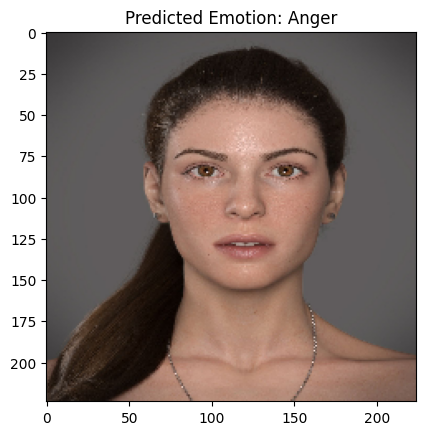

Probability for Anger: 0.3591
Probability for Disgust: 0.0197
Probability for Fear: 0.0534
Probability for Happiness: 0.1210
Probability for Neutral: 0.0206
Probability for Sad: 0.2953
Probability for Surprise: 0.1309

Recommended Songs for Anger: 
                name              artist  popularity  length  mood
5   A Burden to Bear  Emmanuelle Rimbaud          27  129410  Calm
6         A La Plage         Ron Adelaar          29  141888  Calm
11       Adjustments        Josie Mehlin          52  182000  Calm
12            Adrift         Cooper Sams          53  158117  Calm
15    After The Rain          Comet Blue          24  116625  Calm


In [35]:
# Load and preprocessing images
path = "test2.jpg"
img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

# Make predictions
predictions = loaded_model.predict(x)

# Retrieves the emotion label with the highest probability
emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sad', 'Surprise']
predicted_label = emotion_labels[np.argmax(predictions)]
predicted_prob = predictions[0]

# Displays images and emotion predictions
plt.imshow(img)
plt.title(f'Predicted Emotion: {predicted_label}')
plt.show()

# Displays the probability of emotions in each class
for label, prob in zip(emotion_labels, predicted_prob):
    print(f'Probability for {label}: {prob:.4f}')

recommended_songs = recommend_songs(predicted_label)

# Displays song recommendations based on emotional predictions
print(f'\nRecommended Songs for {predicted_label}: \n{recommended_songs}')
